In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm,trange
from Utils.cvt import CvT

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.6799, 0.5269, 0.6096], [0.2699, 0.2932, 0.2703])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.6799, 0.5269, 0.6096], [0.2699, 0.2932, 0.2703])
    ]),
}



data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200, shuffle=True) for x in ['train', 'val']}
dataloaders_show = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def get_mean_std(loader,phase):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader[phase]:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        if num_batches > 100:
            break
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std
# mean, std = get_mean_std(dataloaders,'train')
# print("train")
# print(mean)
# print(std)
# mean, std = get_mean_std(dataloaders,'val')
# print("val")
# print(mean)
# print(std)

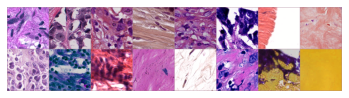

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6799, 0.5269, 0.6096])
    std = np.array([0.2699, 0.2932, 0.2703])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    # if title is not None:
    #     plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_show['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
# print(classes)

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(labels.shape,preds.shape)

            for j in range(inputs.size()[0]):
                if preds[j] != labels[j] and outputs[1][j] > 0.9:
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {} Label: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

In [6]:
def train_model(model, criterion, optimizer, num_epochs=5):
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase]) as t:
                for inputs, labels in t:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.cuda.amp.autocast(enabled=use_amp):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            t.set_postfix(loss_=loss.item(), )

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                scaler.scale(loss).backward()
                                scaler.step(optimizer)
                                scaler.update()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = True
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
Checkpoint_path = r"Checkpoint/resnet18_more_15.pt"
model_ft.load_state_dict(torch.load(Checkpoint_path,map_location=device))
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(torch.Tensor([2.12,1]).to(device))
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=3)
if not os.path.exists('Checkpoint'):
    os.mkdir('Checkpoint')
torch.save(model_ft.state_dict(), os.path.join('Checkpoint', 'resnet18_more_22_01_11.pt'))

Epoch 0/2
----------


100%|██████████| 7082/7082 [2:46:03<00:00,  1.41s/it, loss_=0.106]   


train Loss: 0.1409 Acc: 0.9422


100%|██████████| 1456/1456 [15:31<00:00,  1.56it/s, loss_=0.158] 


val Loss: 0.1431 Acc: 0.9483

Epoch 1/2
----------


100%|██████████| 7082/7082 [2:42:15<00:00,  1.37s/it, loss_=0.0671]  


train Loss: 0.1248 Acc: 0.9488


100%|██████████| 1456/1456 [12:30<00:00,  1.94it/s, loss_=0.16]  


val Loss: 0.1652 Acc: 0.9446

Epoch 2/2
----------


100%|██████████| 7082/7082 [2:41:12<00:00,  1.37s/it, loss_=0.153]   


train Loss: 0.1128 Acc: 0.9542


100%|██████████| 1456/1456 [12:03<00:00,  2.01it/s, loss_=0.16]  

val Loss: 0.1534 Acc: 0.9453

Training complete in 529m 38s
Best val Acc: 0.948274


In [ ]:
visualize_model(model_ft, num_images= 10)

plt.ioff()
plt.show()